In [35]:
import numpy as np
import pandas as pd
%matplotlib inline 
import re
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
plt.rcParams['figure.figsize'] = (20, 15)
import xlsxwriter
import statsmodels.api as sm # import statsmodels 
import scipy
pd.set_option('precision', 2)

In [36]:
#tg 1524411797
#cg1 1524411844
#cg2 1524411880
#tg nr 1524411957
#cg1 nr 1524411998
#cg2 nr 1524412040
#tg r 1524412088
#cg1 r 1524412129
#cg2 r 1524412143

In [37]:
#name of experiment
name = 'Multirun_FullPremListWithoutWeek_IOS_run8'
# files with payments of all users
tg = pd.read_csv(r'C:\Users\user\Downloads\payments-1526031663.csv')
cg1 = pd.read_csv(r'C:\Users\user\Downloads\payments-1526031694.csv')
cg2 = pd.read_csv(r'C:\Users\user\Downloads\payments-1526031708.csv')
tg['group'] = 'tg'
cg1['group'] = 'cg1'
cg2['group'] = 'cg2'
full_df= tg.append(cg1.append(cg2))
#files with payments of nonreferral users
tg = pd.read_csv(r'C:\Users\user\Downloads\payments-1526031727.csv')
cg1 = pd.read_csv(r'C:\Users\user\Downloads\payments-1526031746.csv')
cg2 = pd.read_csv(r'C:\Users\user\Downloads\payments-1526031757.csv')
tg['group'] = 'tg'
cg1['group'] = 'cg1'
cg2['group'] = 'cg2'
nonref_df= tg.append(cg1.append(cg2))
#files with payments of referral users
tg = pd.read_csv(r'C:\Users\user\Downloads\payments-1526031829.csv')
cg1 = pd.read_csv(r'C:\Users\user\Downloads\payments-1526031839.csv')
cg2 = pd.read_csv(r'C:\Users\user\Downloads\payments-1526031855.csv')
tg['group'] = 'tg'
cg1['group'] = 'cg1'
cg2['group'] = 'cg2'
ref_df= tg.append(cg1.append(cg2))

In [38]:
writer = pd.ExcelWriter(r'C:\Users\user\Downloads\analysis_of_experiment_'+name+'.xlsx', engine='openpyxl') 

In [39]:
full_df_prem_only = full_df[list(map(lambda x: ('trial' in str(x)) or ('prem' in str(x)) or ('vip' in str(x)),  full_df['Product Id']))]
nonref_df_prem_only = nonref_df[list(map(lambda x: ('trial' in str(x)) or ('prem' in str(x)) or ('vip' in str(x)),  nonref_df['Product Id']))]
ref_df_prem_only = ref_df[list(map(lambda x: ('trial' in str(x)) or ('prem' in str(x)) or ('vip' in str(x)),  ref_df['Product Id']))]

In [40]:
def primary_pivot_full(full_df, nonref_df, ref_df):
    def primary_pivot(df):
        a = pd.DataFrame(df.groupby('group')['revenue in cents'].sum()).transpose()
        b = pd.DataFrame(df.groupby('group')['revenue in cents'].count()).transpose()
        c = pd.DataFrame(df.groupby('group')['user ID'].nunique()).transpose()
        d = pd.DataFrame(np.asarray(a.values.tolist())/np.asarray(c.values.tolist()), columns = ['cg1', 'cg2', 'tg'])
        m = pd.concat([a,b,c,d], axis = 0, join = 'inner')
        m['dif'] = (m['tg']/((m['cg1']+m['cg2'])/2)-1)
        cols = ['tg', 'cg1', 'cg2', 'dif']
        return m[cols]
    pivot_full = pd.concat([primary_pivot(full_df),primary_pivot(nonref_df),primary_pivot(ref_df)], axis = 1)
    pivot_full.columns = [ 'TG', 'CG1','CG2','dif',
                 'TG_nr', 'CG1_nr','CG2_nr','dif_nr',
                  'TG_r', 'CG1_r','CG2_r','dif_r']
    pivot_full.index = ['revenue', 'purchases' , 'unique buyers', 'revenue per buyer']
    cm = sns.light_palette("yellow", as_cmap=True)
    k=1
    globals()['j'] =  pivot_full.count(axis = 0)[0] + 2
    return (pivot_full.style.format({'dif': '{:.2%}', 'dif_nr': '{:.2%}','dif_r': '{:.2%}'})
           .background_gradient(subset=['dif', 'dif_nr','dif_r'], cmap=cm)
           .to_excel(writer, "Main", startrow = k))

In [41]:
def qunique_len_sum(df_payments_TG, df_payments_CG1, df_payments_CG2):
    a = len(set(df_payments_TG['user ID'])), len(set(df_payments_CG1['user ID'])), len(set(df_payments_CG2['user ID'])), \
    len(df_payments_TG['user ID']), len(df_payments_CG1['user ID']), len(df_payments_CG2['user ID']), \
    df_payments_TG['revenue in cents'].sum(), df_payments_CG1['revenue in cents'].sum(), df_payments_CG2['revenue in cents'].sum()
    return(a)

In [42]:
def products_purchases(df):
    df_payments_TG = df[df['group'] == 'tg']
    df_payments_TG['test group'] = 'TG'
    df_payments_CG1 = df[df['group'] == 'cg1']
    df_payments_CG1['test group'] = 'CG1'
    df_payments_CG2 = df[df['group'] == 'cg2']
    df_payments_CG2['test group'] = 'CG2'
    df_payments = pd.concat([df_payments_TG,df_payments_CG1,df_payments_CG2])
    df_payments['Product Id'] = df_payments['Product Id'].fillna('null')
    df_payments['is_prem'] = df_payments['Product Id'].map(lambda x: bool(bool(re.search('prem',x)) + bool(re.search('vip',x)) + bool(re.search('trial',x))))
    df_payments['is_trial'] = df_payments['Product Id'].map(lambda x:  bool(re.search('trial',x)) )
    df_payments['is_coin'] = df_payments['Product Id'].map(lambda x:  bool(re.search('coin',x)) )
    df_payments['is_like'] = df_payments['Product Id'].map(lambda x:  bool(re.search('like',x)) )
    df_payments['is_bomb'] = df_payments['Product Id'].map(lambda x:  bool(re.search('bomb',x)) )
    df_payments_TG = df_payments[df_payments['test group'] == 'TG']
    df_payments_CG1 = df_payments[df_payments['test group'] == 'CG1']
    df_payments_CG2 = df_payments[df_payments['test group'] == 'CG2']

    revenue_all = qunique_len_sum(df_payments_TG, df_payments_CG1, df_payments_CG2)

    df_payments_TG = df_payments[(df_payments['test group'] == 'TG') & (df_payments['is_prem'] == True)]
    df_payments_CG1 = df_payments[(df_payments['test group'] == 'CG1') & (df_payments['is_prem'] == True)]
    df_payments_CG2 = df_payments[(df_payments['test group'] == 'CG2') & (df_payments['is_prem'] == True)]

    revenue_prem = qunique_len_sum(df_payments_TG, df_payments_CG1, df_payments_CG2)

    df_payments_TG = df_payments[(df_payments['test group'] == 'TG') & (df_payments['is_trial'] == True)]
    df_payments_CG1 = df_payments[(df_payments['test group'] == 'CG1') & (df_payments['is_trial'] == True)]
    df_payments_CG2 = df_payments[(df_payments['test group'] == 'CG2') & (df_payments['is_trial'] == True)]

    revenue_trial = qunique_len_sum(df_payments_TG, df_payments_CG1, df_payments_CG2)

    df_payments_TG = df_payments[(df_payments['test group'] == 'TG') & (df_payments['is_coin'] == True)]
    df_payments_CG1 = df_payments[(df_payments['test group'] == 'CG1') & (df_payments['is_coin'] == True)]
    df_payments_CG2 = df_payments[(df_payments['test group'] == 'CG2') & (df_payments['is_coin'] == True)]

    revenue_coin = qunique_len_sum(df_payments_TG, df_payments_CG1, df_payments_CG2)

    df_payments_TG = df_payments[(df_payments['test group'] == 'TG') & (df_payments['is_like'] == True)]
    df_payments_CG1 = df_payments[(df_payments['test group'] == 'CG1') & (df_payments['is_like'] == True)]
    df_payments_CG2 = df_payments[(df_payments['test group'] == 'CG2') & (df_payments['is_like'] == True)]

    revenue_like = qunique_len_sum(df_payments_TG, df_payments_CG1, df_payments_CG2)

    df_payments_TG = df_payments[(df_payments['test group'] == 'TG') & (df_payments['is_bomb'] == True)]
    df_payments_CG1 = df_payments[(df_payments['test group'] == 'CG1') & (df_payments['is_bomb'] == True)]
    df_payments_CG2 = df_payments[(df_payments['test group'] == 'CG2') & (df_payments['is_bomb'] == True)]

    revenue_bomb = qunique_len_sum(df_payments_TG, df_payments_CG1, df_payments_CG2)

    df_result = pd.DataFrame([revenue_all, revenue_prem, revenue_trial, revenue_coin, revenue_like, revenue_bomb],
                index = ['total', 'prem','trial','coin','like','bomb'],
                columns = ['TG_unique_buyers', 'CG1_unique_buyers', 'CG2_unique_buyers', 
                           'TG_purchases', 'CG1_purchases', 'CG2_purchases',
                           'TG_revenue', 'CG1_revenue','CG2_revenue'])
    df_result['dif_unique_buyers'] = (df_result['TG_unique_buyers']/(df_result['CG1_unique_buyers']+df_result['CG2_unique_buyers'])*2-1)
    df_result['dif_purchases'] = (df_result['TG_purchases']/(df_result['CG1_purchases']+df_result['CG2_purchases'])*2-1)
    df_result['dif_revenue'] = (df_result['TG_revenue']/(df_result['CG1_revenue']+df_result['CG2_revenue'])*2-1)
    cols = ['TG_unique_buyers', 'CG1_unique_buyers', 'CG2_unique_buyers', 'dif_unique_buyers', 
                           'TG_purchases', 'CG1_purchases', 'CG2_purchases', 'dif_purchases', 
                           'TG_revenue', 'CG1_revenue','CG2_revenue', 'dif_revenue']
    return(df_result[cols])


In [43]:
def result_pivot(df1, df2, df3):
    df_total = pd.concat([df1, df2, df3], axis = 1, join = 'inner', ignore_index=True)
    cols = ['TG_unique_buyers', 'CG1_unique_buyers', 'CG2_unique_buyers', 'dif_unique_buyers', 
            'TG_purchases', 'CG1_purchases', 'CG2_purchases', 'dif_purchases', 
            'TG_revenue', 'CG1_revenue','CG2_revenue', 'dif_revenue',
            'TG_unique_buyers_nr', 'CG1_unique_buyers_nr', 'CG2_unique_buyers_nr', 'dif_unique_buyers_nr', 
            'TG_purchases_nr', 'CG1_purchases_nr', 'CG2_purchases_nr', 'dif_purchases_nr', 
            'TG_revenue_nr', 'CG1_revenue_nr','CG2_revenue_nr', 'dif_revenue_nr',
            'TG_unique_buyers_r', 'CG1_unique_buyers_r', 'CG2_unique_buyers_r', 'dif_unique_buyers_r', 
            'TG_purchases_r', 'CG1_purchases_r', 'CG2_purchases_r', 'dif_purchases_r', 
            'TG_revenue_r', 'CG1_revenue_r','CG2_revenue_r', 'dif_revenue_r']
    df_total.columns = cols
    cm = sns.light_palette("yellow", as_cmap=True)
    k=1
    global j
    k+= j        
    globals()['j'] = j + 2 + df_total.count(axis = 0)[0]
    return((df_total[cols].fillna(0).style.format({'dif_unique_buyers': '{:.2%}', 'dif_purchases': '{:.2%}', 'dif_revenue': '{:.2%}', 
                                           'dif_unique_buyers_nr': '{:.2%}', 'dif_purchases_nr': '{:.2%}', 'dif_revenue_nr': '{:.2%}',
                                            'dif_uique_buyers_r': '{:.2%}', 'dif_purchases_r': '{:.2%}', 'dif_reveue_r': '{:.2%}'
                                           })
     .background_gradient(subset=['dif_unique_buyers' , 'dif_purchases' , 'dif_revenue' , 
                                  'dif_unique_buyers_nr' , 'dif_purchases_nr' , 'dif_revenue_nr' ,
                                  'dif_uique_buyers_r' , 'dif_purchases_r' , 'dif_reveue_r' ], cmap=cm)
     .to_excel(writer, "Main", startrow = k)
        ))

In [44]:
def pivot_table_products(df): 
    def pivot_table_products_sum(df):
        df_pivot=df.pivot_table(index='Product Id', 
                           columns='group', 
                           values='revenue in cents',  
                           aggfunc='sum').fillna(0)
        df_pivot['Total'] = df_pivot.sum(axis=1)
        df_pivot['dif'] = (df_pivot['tg']/((df_pivot['cg1']+df_pivot['cg2'])/2)-1)
        cols = ['tg', 'cg1', 'cg2', 'dif']
        return(df_pivot.sort_values(by = 'Total', ascending = False).drop('Total', axis = 1)[cols].head(30))
    def pivot_table_products_count(df):
        df_pivot=df.pivot_table(index='Product Id', 
                           columns='group', 
                           values='revenue in cents',  
                           aggfunc='count').fillna(0)
        df_pivot['Total'] = df_pivot.sum(axis=1)
        df_pivot['dif'] = (df_pivot['tg']/((df_pivot['cg1']+df_pivot['cg2'])/2)-1)
        cols = ['tg', 'cg1', 'cg2', 'dif']
        return(df_pivot.sort_values(by = 'Total', ascending = False).drop('Total', axis = 1)[cols].head(30))
    m = pd.concat([pivot_table_products_sum(df),pivot_table_products_count(df)], axis = 1)
    m.columns = [ 'TG_revenue', 'CG1_revenue','CG2_revenue','dif_revenue',
                  'TG_purchases', 'CG1_purchases', 'CG2_purchases','dif_purchases']
    cm = sns.light_palette("yellow", as_cmap=True)
    m['Total'] = m.sum(axis=1)
    m = (m.sort_values(by = 'Total', ascending = False).drop('Total', axis = 1).head(30).fillna(0))
    return(m)
        

In [45]:
def pivot_table_products_full(full_df, nonref_df, ref_df): 
    df = pd.concat([pivot_table_products(full_df), pivot_table_products(nonref_df), pivot_table_products(ref_df)],
                   axis = 1, join = 'inner', ignore_index=True)
    cm = sns.light_palette("yellow", as_cmap=True)
    df.columns = [ 'TG_revenue', 'CG1_revenue','CG2_revenue','dif_revenue',
                  'TG_purchases', 'CG1_purchases', 'CG2_purchases','dif_purchases', 
                 'TG_revenue_nr', 'CG1_revenue_nr','CG2_revenue_nr','dif_revenue_nr',
                  'TG_purchases_nr', 'CG1_purchases_nr', 'CG2_purchases_nr','dif_purchases_nr',
                  'TG_revenue_r', 'CG1_revenue_r','CG2_revenue_r','dif_revenue_r',
                  'TG_purchases_r', 'CG1_purchases_r', 'CG2_purchases_r','dif_purchases_r']
    df['Total'] = df.sum(axis=1)
    k=1
    global j
    k+= j        
    globals()['j'] = j + df.count(axis = 0)[0]+2
    return(df.sort_values(by = 'Total', ascending = False).drop('Total', axis = 1).head(30).fillna(0)
           .style.format({'dif_revenue': '{:.2%}', 'dif_purchases': '{:.2%}',
                          'dif_revenue_nr': '{:.2%}', 'dif_purchases_nr': '{:.2%}',
                          'dif_revenue_r': '{:.2%}', 'dif_purchases_r': '{:.2%}'})
           .background_gradient(subset=['dif_revenue', 'dif_purchases',
                                        'dif_revenue_nr', 'dif_purchases_nr',
                                        'dif_revenue_r', 'dif_purchases_r'], cmap=cm)
           .to_excel(writer, "Main", startrow = k))

In [46]:
def pivot_table_place(df): 
    def pivot_table_place_sum(df):
        df_pivot=df.pivot_table(index='place', 
                           columns='group', 
                           values='revenue in cents',  
                           aggfunc='sum').fillna(0)
        df_pivot['Total'] = df_pivot.sum(axis=1)
        df_pivot['dif'] = (df_pivot['tg']/((df_pivot['cg1']+df_pivot['cg2'])/2)-1)
        cols = ['tg', 'cg1', 'cg2', 'dif']
        return(df_pivot.sort_values(by = 'Total', ascending = False).drop('Total', axis = 1)[cols].head(30))
    def pivot_table_place_count(df):
        df_pivot=df.pivot_table(index='place', 
                           columns='group', 
                           values='revenue in cents',  
                           aggfunc='count').fillna(0)
        df_pivot['Total'] = df_pivot.sum(axis=1)
        df_pivot['dif'] = (df_pivot['tg']/((df_pivot['cg1']+df_pivot['cg2'])/2)-1)
        cols = ['tg', 'cg1', 'cg2', 'dif']
        return(df_pivot.sort_values(by = 'Total', ascending = False).drop('Total', axis = 1)[cols].head(30))
    m = pd.concat([pivot_table_place_sum(df),pivot_table_place_count(df)], axis = 1)
    m.columns = [ 'TG_revenue', 'CG1_revenue','CG2_revenue','dif_revenue',
                  'TG_purchases', 'CG1_purchases', 'CG2_purchases','dif_purchases']
    cm = sns.light_palette("yellow", as_cmap=True)
    m['Total'] = m.sum(axis=1)
    m = (m.sort_values(by = 'Total', ascending = False).drop('Total', axis = 1).head(30).fillna(0))
    return(m)

In [47]:
def pivot_table_place_full(full_df, nonref_df, ref_df): 
    df = pd.concat([pivot_table_place(full_df), pivot_table_place(nonref_df), pivot_table_place(ref_df)],
                   axis = 1, join = 'inner', ignore_index=True)
    cm = sns.light_palette("yellow", as_cmap=True)
    df.columns = [ 'TG_revenue', 'CG1_revenue','CG2_revenue','dif_revenue',
                  'TG_purchases', 'CG1_purchases', 'CG2_purchases','dif_purchases', 
                 'TG_revenue_nr', 'CG1_revenue_nr','CG2_revenue_nr','dif_revenue_nr',
                  'TG_purchases_nr', 'CG1_purchases_nr', 'CG2_purchases_nr','dif_purchases_nr',
                  'TG_revenue_r', 'CG1_revenue_r','CG2_revenue_r','dif_revenue_r',
                  'TG_purchases_r', 'CG1_purchases_r', 'CG2_purchases_r','dif_purchases_r']
    df['Total'] = df.sum(axis=1)
    k=1
    global j
    k+= j       
    globals()['j'] = j + df.count(axis = 0)[0]+2
    return(df.sort_values(by = 'Total', ascending = False).drop('Total', axis = 1).head(30).fillna(0)
           .style.format({'dif_revenue': '{:.2%}', 'dif_purchases': '{:.2%}',
                          'dif_revenue_nr': '{:.2%}', 'dif_purchases_nr': '{:.2%}',
                          'dif_revenue_r': '{:.2%}', 'dif_purchases_r': '{:.2%}'})
           .background_gradient(subset=['dif_revenue', 'dif_purchases',
                                        'dif_revenue_nr', 'dif_purchases_nr',
                                        'dif_revenue_r', 'dif_purchases_r'], cmap=cm)
           .to_excel(writer, "Main", startrow = k)) 

In [48]:
primary_pivot_full(full_df, nonref_df, ref_df)

In [49]:
result_pivot(products_purchases(full_df), products_purchases(nonref_df), products_purchases(ref_df))

c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [50]:
pivot_table_products_full(full_df, nonref_df, ref_df);

c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\pandas\io\formats\style.py:883: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(s.min() - (rng * low),
c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\pandas\io\formats\style.py:884: RuntimeWarning: invalid value encountered in double_scalars
  s.max() + (rng * high))
c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


In [51]:
pivot_table_place_full(full_df, nonref_df, ref_df);

In [52]:
pivot_table_products_full(full_df_prem_only, nonref_df_prem_only, ref_df_prem_only);

c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\pandas\io\formats\style.py:883: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(s.min() - (rng * low),
c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\pandas\io\formats\style.py:884: RuntimeWarning: invalid value encountered in double_scalars
  s.max() + (rng * high))
c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


In [53]:
pivot_table_place_full(full_df_prem_only, nonref_df_prem_only, ref_df_prem_only);

In [54]:
wb = load_workbook(r'C:\Users\user\Downloads\analysis_of_experiment_'+name+'.xlsx')
sheet = wb.get_sheet_by_name('Main')
df = pd.DataFrame(sheet.values)

c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  


In [55]:
df

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,None,TG,CG1,CG2,dif,TG_nr,CG1_nr,CG2_nr,dif_nr,TG_r,...,None,None,None,None,None,None,None,None,None,None
2,revenue,925791,914137,915624,0.012,228853,251286,220736,-0.03,696938,...,None,None,None,None,None,None,None,None,None,None
3,purchases,1776,2742,2711,-0.35,410,676,617,-0.37,1366,...,None,None,None,None,None,None,None,None,None,None
4,unique buyers,1143,1506,1457,-0.23,248,386,326,-0.3,895,...,None,None,None,None,None,None,None,None,None,None
5,revenue per buyer,8.1e+02,6.1e+02,6.3e+02,0.31,9.2e+02,651,6.8e+02,0.39,7.8e+02,...,None,None,None,None,None,None,None,None,None,None
6,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7,None,TG_unique_buyers,CG1_unique_buyers,CG2_unique_buyers,dif_unique_buyers,TG_purchases,CG1_purchases,CG2_purchases,dif_purchases,TG_revenue,...,CG2_unique_buyers_r,dif_unique_buyers_r,TG_purchases_r,CG1_purchases_r,CG2_purchases_r,dif_purchases_r,TG_revenue_r,CG1_revenue_r,CG2_revenue_r,dif_revenue_r
8,total,1143,1506,1457,-0.23,1776,2742,2711,-0.35,925791,...,1131,-0.2,1366,2066,2094,-0.34,696938,662851,694888,0.027
9,prem,785,1279,1223,-0.37,797,1845,1798,-0.56,696181,...,928,-0.38,582,1353,1374,-0.57,518022,507988,534367,-0.0061


In [56]:
def print_dif(cell):
    return(str((float(str(cell))*100))[0:5]+'%')

r1="Разница в выручке между тестовой и контрольными группами в целом: " +  print_dif(df.iloc[2][4]) + " " + "(" + str(df.iloc[2][1])+ " "+str(df.iloc[2][2])+ " "+str(df.iloc[2][3])+')'
r2="Разница в выручке между тестовой и контрольными группами у органики: " + print_dif(df.iloc[2][8]) + " " + "(" + str(df.iloc[2][5])+ " "+str(df.iloc[2][6])+ " "+str(df.iloc[2][7])+')'
r3="Разница в выручке между тестовой и контрольными группами у закупленных: " + print_dif(df.iloc[2][12]) + " " + "(" + str(df.iloc[2][9])+ " "+str(df.iloc[2][10])+ " "+str(df.iloc[2][11])+')'
r4=''
r5="Разница в выручке на пользователя между тестовой и контрольными группами в целом: " +  print_dif(df.iloc[5][4]) + " " + "(" + str(round(df.iloc[5][1],2))+ " "+str(round(df.iloc[5][5],2))+ " "+str(round(df.iloc[5][3],2))+')'
r6="Разница в выручке на пользователя между тестовой и контрольными группами у органики: " + print_dif(df.iloc[5][8]) + " " + "(" + str(round(df.iloc[5][5],2))+ " "+str(round(df.iloc[5][6],2))+ " "+str(round(df.iloc[5][7],2))+')'
r7="Разница в выручке на пользователя между тестовой и контрольными группами у закупленных: " + print_dif(df.iloc[5][12]) + " " + "(" + str(round(df.iloc[5][9],2))+ " "+str(round(df.iloc[5][10],2))+ " "+str(round(df.iloc[5][11],2))+')'
r8=''

r9="Разница в выручке по прему в целом между тестовой и контрольными группами в целом: " +  print_dif(df.iloc[9][12]) + " " + "(" + str(df.iloc[9][9])+ " "+str(df.iloc[9][10])+ " "+str(df.iloc[9][11])+')'
r10="Разница в выручке по прему в целом между тестовой и контрольными группами у органики: " + print_dif(df.iloc[9][24]) + " " + "(" + str(df.iloc[9][21])+ " "+str(df.iloc[9][22])+ " "+str(df.iloc[9][23])+')'
r11="Разница в выручке по прему в целом между тестовой и контрольными группами у закупленных: " + print_dif(df.iloc[9][36]) + " " + "(" + str(df.iloc[9][33])+ " "+str(df.iloc[9][34])+ " "+str(df.iloc[9][35])+')'
r12=''
r13="Разница в количестве покупок по прему в целом между тестовой и контрольными группами в целом: " +  print_dif(df.iloc[9][8]) + " " + "(" + str(df.iloc[9][5])+ " "+str(df.iloc[9][6])+ " "+str(df.iloc[9][7])+')'
r14="Разница в количестве покупок по прему в целом между тестовой и контрольными группами у органики: " + print_dif(df.iloc[9][20]) + " " + "(" + str(df.iloc[9][17])+ " "+str(df.iloc[9][18])+ " "+str(df.iloc[9][19])+')'
r15="Разница в количестве покупок по прему в целом между тестовой и контрольными группами у закупленных: " + print_dif(df.iloc[9][32]) + " " + "(" + str(df.iloc[9][29])+ " "+str(df.iloc[9][30])+ " "+str(df.iloc[9][31])+')'
r16=''
r17="Разница в выручке по триалу отдельно между тестовой и контрольными группами в целом: " +  print_dif(df.iloc[10][12]) + " " + "(" + str(df.iloc[10][10])+ " "+str(df.iloc[10][10])+ " "+str(df.iloc[10][11])+')'
r18="Разница в выручке по триалу отдельно между тестовой и контрольными группами у органики: " + print_dif(df.iloc[10][24]) + " " + "(" + str(df.iloc[10][21])+ " "+str(df.iloc[10][22])+ " "+str(df.iloc[10][23])+')'
r19="Разница в выручке по триалу отдельно между тестовой и контрольными группами у закупленных: " + print_dif(df.iloc[10][36]) + " " + "(" + str(df.iloc[10][33])+ " "+str(df.iloc[10][34])+ " "+str(df.iloc[10][35])+')'
r20=''
r21="Разница в количестве покупок по триалу отдельно между тестовой и контрольными группами в целом: " +  print_dif(df.iloc[10][8]) + " " + "(" + str(df.iloc[10][5])+ " "+str(df.iloc[10][6])+ " "+str(df.iloc[10][7])+')'
r22="Разница в количестве покупок по триалу отдельно между тестовой и контрольными группами у органики: " + print_dif(df.iloc[10][20]) + " " + "(" + str(df.iloc[10][17])+ " "+str(df.iloc[10][18])+ " "+str(df.iloc[10][19])+')'
r23="Разница в количестве покупок по триалу отдельно между тестовой и контрольными группами у закупленных: " + print_dif(df.iloc[10][32]) + " " + "(" + str(df.iloc[10][29])+ " "+str(df.iloc[10][30])+ " "+str(df.iloc[10][31])+')'

r = [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,r14,r15,r16,r17,r18,r19,r20,r21,r22,r23]
r = pd.DataFrame(r)
r.to_excel(writer, "result", startrow = 1)

writer.save()

In [23]:
#engine ='xlsxwriter'
#workbook = writer.book
#worksheet = writer.sheets['Main']
#worksheet.set_zoom(90)
#percent_fmt = workbook.add_format({'num_format': '0.0%', 'bold': True})

In [24]:
full_df = full_df[list(map(lambda x: ('trial' in str(x)) or ('prem' in str(x)) or ('vip' in str(x)),  full_df['Product Id']))]

In [25]:
for df in (full_df, nonref_df, ref_df):
    df['group'] = df['group'].map({'tg':0,'cg1':1, 'cg2':2})

In [26]:
full_df

,ref ID,partner ID,ref date,user ID,registration date,payment ID,payment date,payment amount,revenue in cents,payment service ID,payment provider,platform,place,country,last app,Product Id,group
0,9427.0,63.0,2018-04-03 08:26:05,117639865,2018-04-03 08:26:04,4,2018-05-06 10:27:05,1397,977,147,Деньги от Google Play,fb,TrialVipPopup,IN,topfacemobappandroid,com.topface.topface.sub.trial.vip.month.13.3da...,0
2,NaN,NaN,NaN,117559440,2018-03-31 03:26:56,4,2018-05-03 05:35:44,794,555,147,Деньги от Google Play,fb,TrialVipPopup,US,topfacemobappandroid,com.topface.topface.sub.trial.vip.month.13.3da...,0
3,8870.0,33.0,2018-04-01 00:15:13,117577046,2018-04-01 00:15:11,6,2018-04-03 08:10:49,999,969,147,Деньги от Payment Ninja,st,PopularUserChatBlock,AZ,topfacemobappandroid,pn.sub.vip.month.10,0
6,9526.0,63.0,2018-04-01 20:30:02,117597632,2018-04-01 20:30:00,3,2018-04-05 05:33:49,997,697,147,Деньги от Google Play,fb,promo.key31,TR,topfacemobappandroid,com.topface.topface.sub.trial.vip.month.13.3da...,0
7,9578.0,63.0,2018-04-03 12:40:38,117643366,2018-04-03 12:40:37,3,2018-04-07 21:26:17,1306,914,147,Деньги от Google Play,gp,TrialVipPopup,CO,topfacemobappandroid,com.topface.topface.sub.trial.vip.month.13.3da...,0
8,9630.0,63.0,2018-04-02 06:15:13,117610387,2018-04-02 06:15:10,3,2018-04-05 09:05:30,1242,869,147,Деньги от Google Play,st,LeftMenu,MX,topfacemobappandroid,com.topface.topface.sub.trial.vip.month.13.3da...,0
9,NaN,NaN,NaN,117576422,2018-03-31 23:40:55,12,2018-05-06 18:20:06,1053,1021,147,Деньги от Payment Ninja,st,promo.key31,FR,topfacemobappandroid,pn.sub.vip.month.10,0
13,9438.0,63.0,2018-04-04 20:14:54,117675711,2018-04-04 20:14:52,1,2018-04-05 22:36:56,999,969,147,Деньги от Payment Ninja,fb,PopularUserBlockDialog,EC,topfacemobappandroid,pn.sub.vip.month.10,0
14,5609.0,45.0,2018-04-02 22:46:48,117631437,2018-04-02 22:46:47,3,2018-04-06 22:37:21,985,689,147,Деньги от Google Play,fb,TrialVipPopup,TR,topfacemobappandroid,com.topface.topface.sub.trial.vip.month.13.3da...,0
16,9712.0,63.0,2018-04-04 22:45:14,117679577,2018-04-04 22:44:51,2,2018-04-04 23:09:53,961,672,147,Деньги от Google Play,fb,LeftMenu,IN,topfacemobappandroid,com.topface.topface.sub.vip.month.10,0


In [27]:
pd.DataFrame(full_df.groupby('user ID')['revenue in cents'].sum().values).describe()

,0
count,848.00
mean,1045.53
std,1026.81
min,8.00
25%,484.00
50%,861.00
75%,1325.50
max,9458.00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0606CD90>]],
      dtype=object)

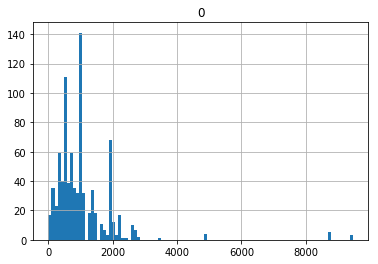

In [28]:
pd.DataFrame(full_df.groupby('user ID')['revenue in cents'].sum().values).hist(bins = 100)

In [29]:
scipy.stats.shapiro(full_df.groupby('user ID')['revenue in cents'].sum().values)

(0.6081000566482544, 5.460762024581309e-40)

In [30]:
scipy.stats.kstest(full_df.groupby('user ID')['revenue in cents'].sum().values, cdf='norm')

KstestResult(statistic=0.9999999999999993, pvalue=0.0)

In [31]:
scipy.stats.kruskal(full_df[full_df['group'] == 0].groupby('user ID')['revenue in cents'].sum().values,
                     full_df[full_df['group'] == 1].groupby('user ID')['revenue in cents'].sum().values,
                     full_df[full_df['group'] == 2].groupby('user ID')['revenue in cents'].sum().values)

KruskalResult(statistic=29.513232906358983, pvalue=3.9019608068618346e-07)

In [32]:
scipy.stats.kruskal(full_df[full_df['group'] == 0].groupby('user ID')['revenue in cents'].sum().values,
                     full_df[(full_df['group'] == 1) | (full_df['group'] == 2)].groupby('user ID')['revenue in cents'].sum().values)

KruskalResult(statistic=29.512708218823164, pvalue=5.5551263980038925e-08)

In [33]:
print(scipy.stats.mannwhitneyu(full_df[full_df['group'] == 0].groupby('user ID')['revenue in cents'].sum().values,
                               full_df[full_df['group'] == 1].groupby('user ID')['revenue in cents'].sum().values).pvalue,
     scipy.stats.mannwhitneyu(full_df[full_df['group'] == 0].groupby('user ID')['revenue in cents'].sum().values,
                               full_df[full_df['group'] == 2].groupby('user ID')['revenue in cents'].sum().values).pvalue,
      scipy.stats.mannwhitneyu(full_df[full_df['group'] == 0].groupby('user ID')['revenue in cents'].sum().values,
                               full_df[(full_df['group'] == 1) | (full_df['group'] == 2)].groupby('user ID')['revenue in cents'].sum().values).pvalue)

1.1123001269026019e-06 6.295270222769618e-07 2.7799789616116165e-08


c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\scipy\stats\stats.py:4871: DeprecationWarning: Calling `mannwhitneyu` without specifying `alternative` is deprecated.
  "`alternative` is deprecated.", DeprecationWarning)


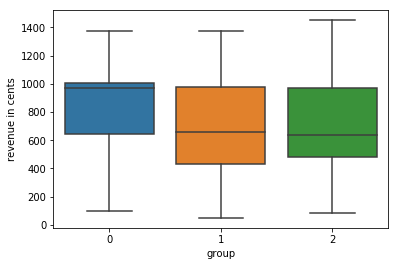

In [34]:
sns.boxplot(x='group', y='revenue in cents', data=full_df, orient="v", showfliers = False)